In [1]:
cardW=62 #57 # 62
cardH=87 
cornerXmin=2 #?1
cornerXmax=10.5 # 7
cornerYmin=2.5 
cornerYmax=23 #19 

# We convert the measures from mm to pixels: multiply by an arbitrary factor 'zoom'
# You shouldn't need to change this
zoom=4
cardW*=zoom
cardH*=zoom
cornerXmin=int(cornerXmin*zoom)
cornerXmax=int(cornerXmax*zoom)
cornerYmin=int(cornerYmin*zoom)
cornerYmax=int(cornerYmax*zoom)

In [2]:
import numpy as np
import cv2
import os
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pickle
from pathlib import Path
import imgaug as ia
from imgaug import augmenters as iaa
from shapely.geometry import Polygon


In [3]:
def display_img(img,polygons=[],channels="bgr",size=9):
    """
        Function to display an inline image, and draw optional polygons (bounding boxes, convex hulls) on it.
        Use the param 'channels' to specify the order of the channels ("bgr" for an image coming from OpenCV world)
    """
    if not isinstance(polygons,list):
        polygons=[polygons]    
    if channels=="bgr": # bgr (cv2 image)
        nb_channels=img.shape[2]
        if nb_channels==4:
            img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
        else:
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)    
    fig,ax=plt.subplots(figsize=(size,size))
    ax.set_facecolor((0,0,0))
    ax.imshow(img)
    for polygon in polygons:
        # An polygon has either shape (n,2), 
        # either (n,1,2) if it is a cv2 contour (like convex hull).
        # In the latter case, reshape in (n,2)
        if len(polygon.shape)==3:
            polygon=polygon.reshape(-1,2)
        patch=patches.Polygon(polygon,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(patch)

def give_me_filename(dirname, suffixes, prefix=""):
    """
        Function that returns a filename or a list of filenames in directory 'dirname'
        that does not exist yet. If 'suffixes' is a list, one filename per suffix in 'suffixes':
        filename = dirname + "/" + prefix + random number + "." + suffix
        Same random number for all the file name
        Ex: 
        > give_me_filename("dir","jpg", prefix="prefix")
        'dir/prefix408290659.jpg'
        > give_me_filename("dir",["jpg","xml"])
        ['dir/877739594.jpg', 'dir/877739594.xml']        
    """
    if not isinstance(suffixes, list):
        suffixes=[suffixes]
    
    suffixes=[p if p[0]=='.' else '.'+p for p in suffixes]
          
    while True:
        bname="%09d"%random.randint(0,999999999)
        fnames=[]
        for suffix in suffixes:
            fname=os.path.join(dirname,prefix+bname+suffix)
            if not os.path.isfile(fname):
                fnames.append(fname)
                
        if len(fnames) == len(suffixes): break
    
    if len(fnames)==1:
        return fnames[0]
    else:
        return fnames

In [4]:
project_path = Path("E:/Study/2022 Winter/COMP4102 Computer Vision/Project")
data_dir=project_path / "data" # Directory that will contain all kinds of data (the data we download and the data we generate)

data_dir.mkdir(exist_ok=True)


card_suits=['s','h','d','c']
card_values=['A','K','Q','J','10','9','8','7','6','5','4','3','2']

# Pickle file containing the background images from the DTD
backgrounds_pck_fn=data_dir/"backgrounds.pck"

# Pickle file containing the card images
cards_pck_fn=data_dir/"cards.pck"


# imgW,imgH: dimensions of the generated dataset images 
imgW=720
imgH=720


refCard=np.array([[0,0],[cardW,0],[cardW,cardH],[0,cardH]],dtype=np.float32)
refCardRot=np.array([[cardW,0],[cardW,cardH],[0,cardH],[0,0]],dtype=np.float32)
refCornerHL=np.array([[cornerXmin,cornerYmin],[cornerXmax,cornerYmin],[cornerXmax,cornerYmax],[cornerXmin,cornerYmax]],dtype=np.float32)
refCornerLR=np.array([[cardW-cornerXmax,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmin],[cardW-cornerXmax,cardH-cornerYmin]],dtype=np.float32)
refCorners=np.array([refCornerHL,refCornerLR])

In [5]:
# dtd_dir= "/dtd/images/"
# dtd_dir_path = project_path / "dtd" / "images"
# bg_images=[]
# print(dtd_dir_path)
# for f in dtd_dir_path.glob('**/*.jpg'):
#         bg_images.append(mpimg.imread(f))
# print("Nb of images loaded :",len(bg_images))
# print("Saved in :",backgrounds_pck_fn)
# pickle.dump(bg_images,open(backgrounds_pck_fn,'wb'))

In [6]:
class Backgrounds():
    def __init__(self,backgrounds_pck_fn=backgrounds_pck_fn):
        self._images=pickle.load(open(backgrounds_pck_fn,'rb'))
        self._nb_images=len(self._images)
        print("Nb of images loaded :", self._nb_images)
    def get_random(self, display=False):
        bg=self._images[random.randint(0,self._nb_images-1)]
        if display: plt.imshow(bg)
        return bg
    
backgrounds = Backgrounds()

Nb of images loaded : 5640


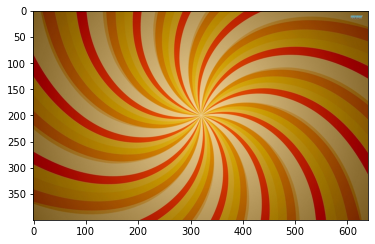

In [7]:
# Test: display a random background
_=backgrounds.get_random(display=True)

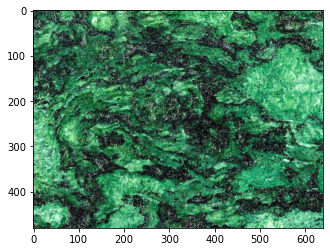

In [8]:
# Test: display a random background
_=backgrounds.get_random(display=True)

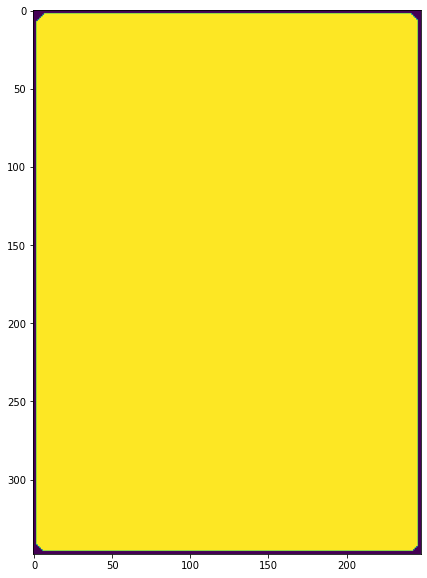

In [9]:
bord_size=2 # bord_size alpha=0
alphamask=np.ones((cardH,cardW),dtype=np.uint8)*255
cv2.rectangle(alphamask,(0,0),(cardW-1,cardH-1),0,bord_size)
cv2.line(alphamask,(bord_size*3,0),(0,bord_size*3),0,bord_size)
cv2.line(alphamask,(cardW-bord_size*3,0),(cardW,bord_size*3),0,bord_size)
cv2.line(alphamask,(0,cardH-bord_size*3),(bord_size*3,cardH),0,bord_size)
cv2.line(alphamask,(cardW-bord_size*3,cardH),(cardW,cardH-bord_size*3),0,bord_size)
plt.figure(figsize=(10,10))
plt.imshow(alphamask)

In [10]:
def varianceOfLaplacian(img):
    """
    Compute the Laplacian of the image and then return the focus
    measure, which is simply the variance of the Laplacian
    Source: A.Rosebrock, https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/
    """
    return cv2.Laplacian(img, cv2.CV_64F).var()

def extract_card (img, output_fn=None, min_focus=85, debug=False):
    """
    """
    
    imgwarp=None
    
    # Check the image is not too blurry
    focus=varianceOfLaplacian(img)
    if focus < min_focus: 
        if debug: print("Focus too low :", focus)
        return False,None    
    # Convert in gray color
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Noise-reducing and edge-preserving filter
    gray=cv2.bilateralFilter(gray,11,17,17)
    
    # Edge extraction
    edge=cv2.Canny(gray,30,200)
    
    # Find the contours in the edged image
    cnts, _ = cv2.findContours(edge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
    # We suppose that the contour with largest area corresponds to the contour delimiting the card
    cnt = max(cnts, key = cv2.contourArea)
        
    # We want to check that 'cnt' is the contour of a rectangular shape
    # First, determine 'box', the minimum area bounding rectangle of 'cnt'
    # Then compare area of 'cnt' and area of 'box'
    # Both areas sould be very close
    rect=cv2.minAreaRect(cnt)
    box=cv2.boxPoints(rect)
    box=np.int64(box)
    areaCnt=cv2.contourArea(cnt)
    areaBox=cv2.contourArea(box)
    valid=areaCnt/areaBox>0.95
    
    if valid:
        # We want transform the zone inside the contour into the reference rectangle of dimensions (cardW,cardH)
        ((xr,yr),(wr,hr),thetar)=rect
        # Determine 'Mp' the transformation that transforms 'box' into the reference rectangle
        if wr>hr:
            Mp=cv2.getPerspectiveTransform(np.float32(box),refCard)
        else:
            Mp=cv2.getPerspectiveTransform(np.float32(box),refCardRot)
        
        
        # Determine the warped image by applying the transformation to the image
        imgwarp=cv2.warpPerspective(img,Mp,(cardW,cardH))
        # Add alpha layer
        imgwarp=cv2.cvtColor(imgwarp,cv2.COLOR_BGR2BGRA)
        

        
        # Shape of 'cnt' is (n,1,2), type=int with n = number of points
        # We reshape into (1,n,2), type=float32, before feeding to perspectiveTransform
        cnta=cnt.reshape(1,-1,2).astype(np.float32)
        

        # Apply the transformation 'Mp' to the contour
        cntwarp=cv2.perspectiveTransform(cnta,Mp)
        cntwarp=cntwarp.astype(np.int64)
        
        
        # We build the alpha channel so that we have transparency on the
        # external border of the card
        # First, initialize alpha channel fully transparent
        alphachannel=np.zeros(imgwarp.shape[:2],dtype=np.uint8)

        
        
        # Then fill in the contour to make opaque this zone of the card 
        cv2.drawContours(alphachannel,cntwarp,0,255,-1)

        
        # Apply the alphamask onto the alpha channel to clean it
        alphachannel=cv2.bitwise_and(alphachannel,alphamask)

        # Add the alphachannel to the warped image
        imgwarp[:,:,3]=alphachannel
        
        # Save the image to file
        if output_fn is not None:
            cv2.imwrite(output_fn,imgwarp)
        
    if debug:
        cv2.imshow("Gray",gray)
        cv2.imshow("Canny",edge)
        edge_bgr=cv2.cvtColor(edge,cv2.COLOR_GRAY2BGR)
        cv2.drawContours(edge_bgr,[box],0,(0,0,255),3)
        cv2.drawContours(edge_bgr,[cnt],0,(0,255,0),-1)
        cv2.imshow("Contour with biggest area",edge_bgr)
        if valid:
            cv2.imshow("Alphachannel",alphachannel)
            cv2.imshow("Extracted card",imgwarp)

    return valid,imgwarp

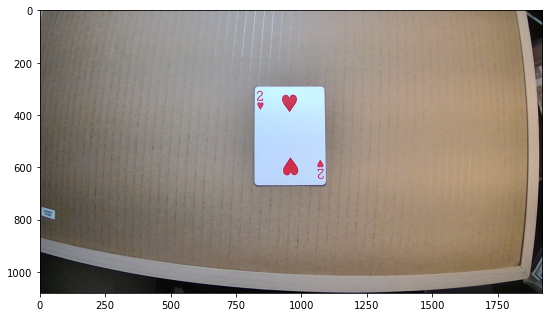

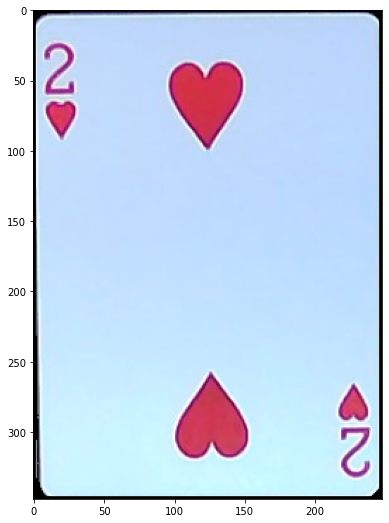

In [11]:
test_path = project_path / "test"
scene_path = test_path / "scene.jpg"

# Test on one image
debug=False
img=cv2.imread(str(scene_path))
display_img(img)
valid,card=extract_card(img,str(test_path / "extracted_card.jpg"), debug=True)
if valid:
    display_img(card)
if debug:
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [12]:
def extract_cards_from_video(video_fn, output_dir=None, keep_ratio=5, min_focus=100, debug=False):
    """
        Extract cards from media file 'video_fn' 
        If 'output_dir' is specified, the cards are saved in 'output_dir'.
        One file per card with a random file name
        Because 2 consecutives frames are probably very similar, we don't use every frame of the video, 
        but only one every 'keep_ratio' frames
        
        Returns list of extracted images
    """
    if not os.path.isfile(video_fn):
        print(f"Video file {video_fn} does not exist !!!")
        return -1,[]
    if output_dir is not None and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    cap=cv2.VideoCapture(video_fn)
    
    frame_nb=0
    imgs_list=[]
    while True:
        ret,img=cap.read()
        if not ret: break
        # Work on every 'keep_ratio' frames
        if frame_nb%keep_ratio==0:
            if output_dir is not None:
                output_fn=give_me_filename(output_dir,"png")
            else:
                output_fn=None
            valid,card_img = extract_card(img,output_fn,min_focus=min_focus,debug=debug)
            if debug: 
                k=cv2.waitKey(1)
                if k==27: break
            if valid:
                imgs_list.append(card_img)
        frame_nb+=1
    
    if debug:
        cap.release()
        cv2.destroyAllWindows()
    
    return imgs_list

In [13]:
video_dir= data_dir / "video"
extension="mp4"
imgs_dir= data_dir / "cards"

# for suit in card_suits:
#     for value in card_values:
        
#         card_name=value+suit
#         video_fn=os.path.join(video_dir,card_name+"."+extension)
#         output_dir=os.path.join(imgs_dir,card_name)
#         if not os.path.isdir(output_dir):
#             os.makedirs(output_dir)
#         imgs=extract_cards_from_video(video_fn,output_dir)
#         print("Extracted images for %s : %d"%(card_name,len(imgs)))

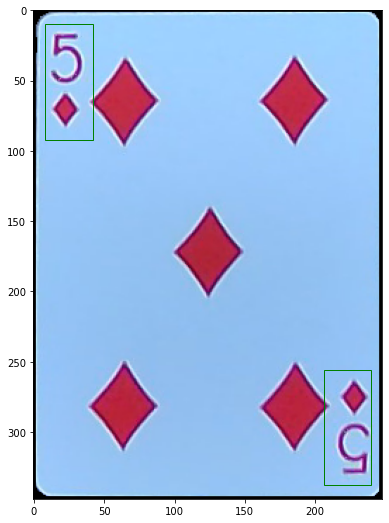

In [14]:
# Run a few times...
imgs_dir=data_dir / "cards"
imgs_fns=list(imgs_dir.glob("**/*.png"))
img_fn=random.choice(imgs_fns)
display_img(cv2.imread(str(img_fn),cv2.IMREAD_UNCHANGED),polygons=[refCornerHL,refCornerLR])

In [15]:
def findHull(img, corner=refCornerHL, debug="no"):
    """
        Find in the zone 'corner' of image 'img' and return, the convex hull delimiting
        the value and suit symbols
        'corner' (shape (4,2)) is an array of 4 points delimiting a rectangular zone, 
        takes one of the 2 possible values : refCornerHL or refCornerLR
        debug=
    """
    
    kernel = np.ones((3,3),np.uint8)
    corner=corner.astype(np.int64)

    # We will focus on the zone of 'img' delimited by 'corner'
    x1=int(corner[0][0])
    y1=int(corner[0][1])
    x2=int(corner[2][0])
    y2=int(corner[2][1])
    w=x2-x1
    h=y2-y1
    zone=img[y1:y2,x1:x2].copy()

    strange_cnt=np.zeros_like(zone)
    gray=cv2.cvtColor(zone,cv2.COLOR_BGR2GRAY)
    thld=cv2.Canny(gray,30,200)
    thld = cv2.dilate(thld,kernel,iterations=1)
    if debug!="no": cv2.imshow("thld",thld)
    
    # Find the contours
    contours, _ =cv2.findContours(thld.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    min_area=30 # We will reject contours with small area. TWEAK, 'zoom' dependant
    min_solidity=0.3 # Reject contours with a low solidity. TWEAK
    
    concat_contour=None # We will aggregate in 'concat_contour' the contours that we want to keep
    
    ok=True
    print()
    for c in contours:
        area=cv2.contourArea(c)

        hull = cv2.convexHull(c)
        hull_area = cv2.contourArea(hull)
        solidity = float(area)/hull_area
        # Determine the center of gravity (cx,cy) of the contour
        M=cv2.moments(c)
        cx=int(M['m10']/M['m00'])
        cy=int(M['m01']/M['m00'])
        #  abs(w/2-cx)<w*0.3 and abs(h/2-cy)<h*0.4 : TWEAK, the idea here is to keep only the contours which are closed to the center of the zone
        if area >= min_area and abs(w/2-cx)<w*0.3 and abs(h/2-cy)<h*0.4 and solidity>min_solidity:
            if debug != "no" :
                cv2.drawContours(zone,[c],0,(255,0,0),-1)
            if concat_contour is None:
                concat_contour=c
            else:
                concat_contour=np.concatenate((concat_contour,c))
        if debug != "no" and solidity <= min_solidity :
            print("Solidity",solidity)
            cv2.drawContours(strange_cnt,[c],0,255,2)
            cv2.imshow("Strange contours",strange_cnt)
            
     
    if concat_contour is not None:
        # At this point, we suppose that 'concat_contour' contains only the contours corresponding the value and suit symbols   
        # We can now determine the hull
        hull=cv2.convexHull(concat_contour)
        hull_area=cv2.contourArea(hull)
        # If the area of the hull is to small or too big, there may be a problem
        min_hull_area=940 # TWEAK, deck and 'zoom' dependant
        max_hull_area=2120 # TWEAK, deck and 'zoom' dependant
        if hull_area < min_hull_area or hull_area > max_hull_area: 
            ok=False
            if debug!="no":
                print("Hull area=",hull_area,"too large or too small")
        # So far, the coordinates of the hull are relative to 'zone'
        # We need the coordinates relative to the image -> 'hull_in_img' 
        hull_in_img=hull+corner[0]

    else:
        ok=False
    
    
    if debug != "no" :
        if concat_contour is not None:
            cv2.drawContours(zone,[hull],0,(0,255,0),1)
            cv2.drawContours(img,[hull_in_img],0,(0,255,0),1)
        cv2.imshow("Zone",zone)
        cv2.imshow("Image",img)
        if ok and debug!="pause_always":
            key=cv2.waitKey(1)
        else:
            key=cv2.waitKey(0)
        if key==27:
            return None
    if ok == False:
        
        return None
    
    return hull_in_img

E:\Study\2022 Winter\COMP4102 Computer Vision\Project\data\cards\2s\482961795.png




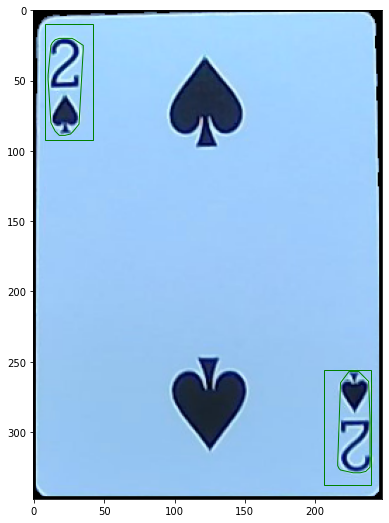

In [16]:
# Test find_hull on a random card image
# debug = "no" or "pause_always" or "pause_on_pb"
# If debug!="no", you may have to press a key to continue execution after pause
debug="no" 
imgs_dir=data_dir / "cards"
imgs_fns=list(imgs_dir.glob("**/*.png"))
img_fn=random.choice(imgs_fns)
print(img_fn)
img=cv2.imread(str(img_fn),cv2.IMREAD_UNCHANGED)

hullHL=findHull(img,refCornerHL,debug=debug)
hullLR=findHull(img,refCornerLR,debug=debug)
display_img(img,[refCornerHL,refCornerLR,hullHL,hullLR])

if debug!="no": cv2.destroyAllWindows()

# Load all images of cards, calculate their convex hulls and save the whole in a pickle file 


In [17]:
cards={}
for suit in card_suits:
    for value in card_values:
        card_name=value+suit        
        card_dir=imgs_dir / card_name
        if not card_dir.is_dir():
            print(f"{str(card_dir)} does not exist !!!\n")
            continue
        cards[card_name]=[]
        for f in list(card_dir.glob("**/*.png")):
            f = str(f)
            img=cv2.imread(f,cv2.IMREAD_UNCHANGED)
            hullHL=findHull(img,refCornerHL,debug="no") 
            if hullHL is None: 
                print(f"File {f} not used.\n")
                continue
            hullLR=findHull(img,refCornerLR,debug="no") 
            if hullLR is None: 
                print(f"File {f} not used.\n")
                continue
            # We store the image in "rgb" format (we don't need opencv anymore)
            img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
            cards[card_name].append((img,hullHL,hullLR))
        print(f"Nb images for {card_name} : {len(cards[card_name])}")



print("Saved in :",cards_pck_fn)
pickle.dump(cards,open(cards_pck_fn,'wb'))

cv2.destroyAllWindows()

























































































































Nb images for As : 60


File E:\Study\2022 Winter\COMP4102 Computer Vision\Project\data\cards\Ks\013544735.png not used.









File E:\Study\2022 Winter\COMP4102 Computer Vision\Project\data\cards\Ks\075926417.png not used.





File E:\Study\2022 Winter\COMP4102 Computer Vision\Project\data\cards\Ks\115840626.png not used.









File E:\Study\2022 Winter\COMP4102 Computer Vision\Project\data\cards\Ks\218714300.png not used.



File E:\Study\2022 Winter\COMP4102 Computer Vision\Project\data\cards\Ks\231152733.png not used.




File E:\Study\2022 Winter\COMP4102 Computer Vision\Project\data\cards\Ks\244799199.png not used.







File E:\Study\2022 Winter\COMP4102 Computer Vision\Project\data\cards\Ks\276101705.png not used.



File E:\Study\2022 Winter\COMP4102 Computer Vision\Project\data\cards\Ks\292400152.png not used.





File E:\Study\2022 Winter\COMP4102 




















































Nb images for Qh : 56
























































































































Nb images for Jh : 60














































































































Nb images for 10h : 55














































































































Nb images for 9h : 55














































































































































Nb images for 8h : 71


















































































































Nb images for 7h : 57






































































Nb images for 6h : 35




















































































Nb images for 5h : 42
























File E:\Study\2022 Winter\COMP4102 Computer Vision\Project\data\cards\Qc\854969179.png not used.




File E:\Study\2022 Winter\COMP4102 Computer Vision\Project\data\cards\Qc\939103538.png not used.










File E:\Study\2022 Winter\COMP4102 Computer Vision\Project\data\cards\Qc\974526655.png not used.




File E:\Study\2022 Winter\COMP4102 Computer Vision\Project\data\cards\Qc\981661836.png not used.


File E:\Study\2022 Winter\COMP4102 Computer Vision\Project\data\cards\Qc\984994020.png not used.


File E:\Study\2022 Winter\COMP4102 Computer Vision\Project\data\cards\Qc\986794683.png not used.



Nb images for Qc : 37


























































































































Nb images for Jc : 61






































































































Nb images for 10c : 51








































































































In [18]:
class Cards():
    def __init__(self,cards_pck_fn=cards_pck_fn):
        self._cards=pickle.load(open(cards_pck_fn,'rb'))
        # self._cards is a dictionary where keys are card names (ex:'Kc') and values are lists of (img,hullHL,hullLR) 
        self._nb_cards_by_value={k:len(self._cards[k]) for k in self._cards}
        print("Nb of cards loaded per name :", self._nb_cards_by_value)
        
    def get_random(self, card_name=None, display=False):
        if card_name is None:
            card_name= random.choice(list(self._cards.keys()))
        card,hull1,hull2=self._cards[card_name][random.randint(0,self._nb_cards_by_value[card_name]-1)]
        if display:
            if display: display_img(card,[hull1,hull2],"rgb")
        return card,card_name,hull1,hull2
    
cards = Cards()

Nb of cards loaded per name : {'As': 60, 'Ks': 32, 'Qs': 50, 'Js': 53, '10s': 59, '9s': 54, '8s': 61, '7s': 74, '6s': 51, '5s': 103, '4s': 67, '3s': 50, '2s': 44, 'Ah': 39, 'Kh': 28, 'Qh': 56, 'Jh': 60, '10h': 55, '9h': 55, '8h': 71, '7h': 57, '6h': 35, '5h': 42, '4h': 38, '3h': 33, '2h': 43, 'Ad': 24, 'Kd': 57, 'Qd': 51, 'Jd': 73, '10d': 50, '9d': 75, '8d': 62, '7d': 56, '6d': 82, '5d': 41, '4d': 38, '3d': 49, '2d': 18, 'Ac': 39, 'Kc': 30, 'Qc': 37, 'Jc': 61, '10c': 51, '9c': 61, '8c': 49, '7c': 53, '6c': 52, '5c': 56, '4c': 71, '3c': 68, '2c': 55}


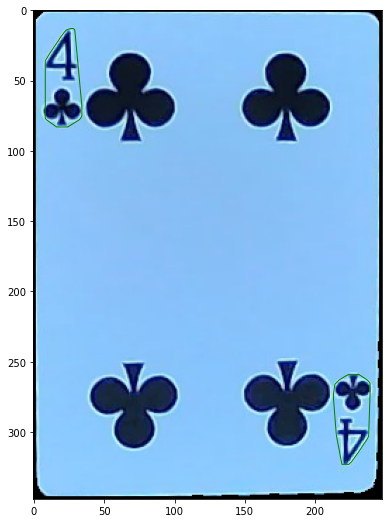

In [19]:
# Test: display a random card
_=cards.get_random(display=True)
# Display a random Ace of spades
#_=cards.get_random("As",display=True)

# Generate Scenes with cards and random backgrounds


First we need to save bounding boxes for images in pascal vox format

In [20]:
xml_body_1="""<annotation>
        <folder>FOLDER</folder>
        <filename>{FILENAME}</filename>
        <path>{PATH}</path>
        <source>
                <database>Unknown</database>
        </source>
        <size>
                <width>{WIDTH}</width>
                <height>{HEIGHT}</height>
                <depth>3</depth>
        </size>
"""
xml_object=""" <object>
                <name>{CLASS}</name>
                <pose>Unspecified</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                        <xmin>{XMIN}</xmin>
                        <ymin>{YMIN}</ymin>
                        <xmax>{XMAX}</xmax>
                        <ymax>{YMAX}</ymax>
                </bndbox>
        </object>
"""
xml_body_2="""</annotation>        
"""

def create_voc_xml(xml_file, img_file,listbba,display=False):
    with open(xml_file,"w") as f:
        f.write(xml_body_1.format(**{'FILENAME':os.path.basename(img_file), 'PATH':img_file,'WIDTH':imgW,'HEIGHT':imgH}))
        for bba in listbba:            
            f.write(xml_object.format(**{'CLASS':bba.classname,'XMIN':bba.x1,'YMIN':bba.y1,'XMAX':bba.x2,'YMAX':bba.y2}))
        f.write(xml_body_2)
        if display: print("New xml",xml_file)

In [21]:
# Scenario with 2 cards:
# The original image of a card has the shape (cardH,cardW,4)
# We first paste it in a zero image of shape (imgH,imgW,4) at position decalX, decalY
# so that the original image is centerd in the zero image
decalX=int((imgW-cardW)/2)
decalY=int((imgH-cardH)/2)


# Scenario with 3 cards : decal values are different
decalX3=int(imgW/2)
decalY3=int(imgH/2-cardH)

def kps_to_polygon(kps):
    """
        Convert imgaug keypoints to shapely polygon
    """
    pts=[(kp.x,kp.y) for kp in kps]
    return Polygon(pts)

def hull_to_kps(hull, decalX=decalX, decalY=decalY):
    """
        Convert hull to imgaug keypoints
    """
    # hull is a cv2.Contour, shape : Nx1x2
    kps=[ia.Keypoint(x=p[0]+decalX,y=p[1]+decalY) for p in hull.reshape(-1,2)]
    kps=ia.KeypointsOnImage(kps, shape=(imgH,imgW,3))
    return kps

def kps_to_BB(kps):
    """
        Determine imgaug bounding box from imgaug keypoints
    """
    extend=3 # To make the bounding box a little bit bigger
    kpsx=[kp.x for kp in kps.keypoints]
    minx=max(0,int(min(kpsx)-extend))
    maxx=min(imgW,int(max(kpsx)+extend))
    kpsy=[kp.y for kp in kps.keypoints]
    miny=max(0,int(min(kpsy)-extend))
    maxy=min(imgH,int(max(kpsy)+extend))
    if minx==maxx or miny==maxy:
        return None
    else:
        return ia.BoundingBox(x1=minx,y1=miny,x2=maxx,y2=maxy)


# imgaug keypoints of the bounding box of a whole card
cardKP = ia.KeypointsOnImage([
    ia.Keypoint(x=decalX,y=decalY),
    ia.Keypoint(x=decalX+cardW,y=decalY),   
    ia.Keypoint(x=decalX+cardW,y=decalY+cardH),
    ia.Keypoint(x=decalX,y=decalY+cardH)
    ], shape=(imgH,imgW,3))

# imgaug transformation for one card in scenario with 2 cards
transform_1card = iaa.Sequential([
    iaa.Affine(scale=[0.65,1]),
    iaa.Affine(rotate=(-180,180)),
    iaa.Affine(translate_percent={"x":(-0.25,0.25),"y":(-0.25,0.25)}),
])

# For the 3 cards scenario, we use 3 imgaug transforms, the first 2 are for individual cards, 
# and the third one for the group of 3 cards
trans_rot1 = iaa.Sequential([
    iaa.Affine(translate_px={"x": (10, 20)}),
    iaa.Affine(rotate=(22,30))
])
trans_rot2 = iaa.Sequential([
    iaa.Affine(translate_px={"x": (0, 5)}),
    iaa.Affine(rotate=(10,15))
])
transform_3cards = iaa.Sequential([
    iaa.Affine(translate_px={"x":decalX-decalX3,"y":decalY-decalY3}),
    iaa.Affine(scale=[0.65,1]),
    iaa.Affine(rotate=(-180,180)),
    iaa.Affine(translate_percent={"x":(-0.2,0.2),"y":(-0.2,0.2)})   
])

# imgaug transformation for the background
scaleBg=iaa.Resize({"height": imgH, "width": imgW})

def augment(img, list_kps, seq, restart=True):
    """
        Apply augmentation 'seq' to image 'img' and keypoints 'list_kps'
        If restart is False, the augmentation has been made deterministic outside the function (used for 3 cards scenario)
    """ 
    # Make sequence deterministic
    while True:
        if restart:
            myseq=seq.to_deterministic()
        else:
            myseq=seq
        # Augment image, keypoints and bbs 
        img_aug = myseq.augment_images([img])[0]
        list_kps_aug = [myseq.augment_keypoints([kp])[0] for kp in list_kps]
        list_bbs = [kps_to_BB(list_kps_aug[1]),kps_to_BB(list_kps_aug[2])]
        valid=True
        # Check the card bounding box stays inside the image
        for bb in list_bbs:
            if bb is None or int(round(bb.x2)) >= imgW or int(round(bb.y2)) >= imgH or int(bb.x1)<=0 or int(bb.y1)<=0:
                valid=False
                break
        if valid: break
        elif not restart:
            img_aug=None
            break
                
    return img_aug,list_kps_aug,list_bbs

class BBA:  # Bounding box + annotations
    def __init__(self,bb,classname):      
        self.x1=int(round(bb.x1))
        self.y1=int(round(bb.y1))
        self.x2=int(round(bb.x2))
        self.y2=int(round(bb.y2))
        self.classname=classname

class Scene:
    def __init__(self,bg,img1, class1, hulla1,hullb1,img2, class2,hulla2,hullb2,img3=None, class3=None,hulla3=None,hullb3=None):
        if img3 is not None:
            self.create3CardsScene(bg,img1, class1, hulla1,hullb1,img2, class2,hulla2,hullb2,img3, class3,hulla3,hullb3)
        else:
            self.create2CardsScene(bg,img1, class1, hulla1,hullb1,img2, class2,hulla2,hullb2)

    def create2CardsScene(self,bg,img1, class1, hulla1,hullb1,img2, class2,hulla2,hullb2):
        kpsa1=hull_to_kps(hulla1)
        kpsb1=hull_to_kps(hullb1)
        kpsa2=hull_to_kps(hulla2)
        kpsb2=hull_to_kps(hullb2)
        
        # Randomly transform 1st card
        self.img1=np.zeros((imgH,imgW,4),dtype=np.uint8)
        print(self.img1.shape)
        self.img1[decalY:decalY+cardH,decalX:decalX+cardW,:]=img1
        self.img1,self.lkps1,self.bbs1=augment(self.img1,[cardKP,kpsa1,kpsb1],transform_1card)

        # Randomly transform 2nd card. We want that card 2 does not partially cover a corner of 1 card.
        # If so, we apply a new random transform to card 2
        while True:
            self.listbba=[]
            self.img2=np.zeros((imgH,imgW,4),dtype=np.uint8)
            self.img2[decalY:decalY+cardH,decalX:decalX+cardW,:]=img2
            self.img2,self.lkps2,self.bbs2=augment(self.img2,[cardKP,kpsa2,kpsb2],transform_1card)

            # mainPoly2: shapely polygon of card 2
            mainPoly2=kps_to_polygon(self.lkps2[0].keypoints[0:4])
            invalid=False
            intersect_ratio=0.1
            for i in range(1,3):
                # smallPoly1: shapely polygon of one of the hull of card 1
                smallPoly1=kps_to_polygon(self.lkps1[i].keypoints[:])
                a=smallPoly1.area
                # We calculate area of the intersection of card 1 corner with card 2
                intersect=mainPoly2.intersection(smallPoly1)
                ai=intersect.area
                # If intersection area is small enough, we accept card 2
                if (a-ai)/a > 1-intersect_ratio:
                    self.listbba.append(BBA(self.bbs1[i-1],class1))
                # If intersectio area is not small, but also not big enough, we want apply new transform to card 2
                elif (a-ai)/a>intersect_ratio:
                    invalid=True
                    break
                    
            if not invalid: break
            
        self.class1=class1
        self.class2=class2
        for bb in self.bbs2:
            self.listbba.append(BBA(bb,class2))
        # Construct final image of the scene by superimposing: bg, img1 and img2
        self.bg=scaleBg.augment_image(bg)
        mask1=self.img1[:,:,3]
        self.mask1=np.stack([mask1]*3,-1)
        self.final=np.where(self.mask1,self.img1[:,:,0:3],self.bg)
        mask2=self.img2[:,:,3]
        self.mask2=np.stack([mask2]*3,-1)
        self.final=np.where(self.mask2,self.img2[:,:,0:3],self.final)
        
        
        
    def create3CardsScene(self,bg,img1, class1, hulla1,hullb1,img2, class2,hulla2,hullb2,img3, class3,hulla3,hullb3):
        
        kpsa1=hull_to_kps(hulla1,decalX3,decalY3)
        kpsb1=hull_to_kps(hullb1,decalX3,decalY3)
        kpsa2=hull_to_kps(hulla2,decalX3,decalY3)
        kpsb2=hull_to_kps(hullb2,decalX3,decalY3)
        kpsa3=hull_to_kps(hulla3,decalX3,decalY3)
        kpsb3=hull_to_kps(hullb3,decalX3,decalY3)
        self.img3=np.zeros((imgH,imgW,4),dtype=np.uint8)
        self.img3[decalY3:decalY3+cardH,decalX3:decalX3+cardW,:]=img3
        self.img3,self.lkps3,self.bbs3=augment(self.img3,[cardKP,kpsa3,kpsb3],trans_rot1)
        self.img2=np.zeros((imgH,imgW,4),dtype=np.uint8)
        self.img2[decalY3:decalY3+cardH,decalX3:decalX3+cardW,:]=img2
        self.img2,self.lkps2,self.bbs2=augment(self.img2,[cardKP,kpsa2,kpsb2],trans_rot2)
        self.img1=np.zeros((imgH,imgW,4),dtype=np.uint8)
        self.img1[decalY3:decalY3+cardH,decalX3:decalX3+cardW,:]=img1

        while True:
            det_transform_3cards = transform_3cards.to_deterministic()
            _img3,_lkps3,self.bbs3=augment(self.img3,self.lkps3,det_transform_3cards, False)
            if _img3 is None: continue
            _img2,_lkps2,self.bbs2=augment(self.img2,self.lkps2,det_transform_3cards, False)
            if _img2 is None: continue
            _img1,self.lkps1,self.bbs1=augment(self.img1,[cardKP,kpsa1,kpsb1],det_transform_3cards, False)
            if _img1 is None: continue
            break
        self.img3=_img3
        self.lkps3=_lkps3
        self.img2=_img2
        self.lkps2=_lkps2
        self.img1=_img1
        
        self.class1=class1
        self.class2=class2
        self.class3=class3
        self.listbba=[BBA(self.bbs1[0],class1),BBA(self.bbs2[0],class2),BBA(self.bbs3[0],class3),BBA(self.bbs3[1],class3)]
        
        # Construct final image of the scene by superimposing: bg, img1, img2 and img3
        self.bg=scaleBg.augment_image(bg)
        mask1=self.img1[:,:,3]
        self.mask1=np.stack([mask1]*3,-1)
        self.final=np.where(self.mask1,self.img1[:,:,0:3],self.bg)
        mask2=self.img2[:,:,3]
        self.mask2=np.stack([mask2]*3,-1)
        self.final=np.where(self.mask2,self.img2[:,:,0:3],self.final)
        mask3=self.img3[:,:,3]
        self.mask3=np.stack([mask3]*3,-1)
        self.final=np.where(self.mask3,self.img3[:,:,0:3],self.final)

    def display(self):
        fig,ax=plt.subplots(1,figsize=(8,8))
        ax.imshow(self.final)
        for bb in self.listbba:
            rect=patches.Rectangle((bb.x1,bb.y1),bb.x2-bb.x1,bb.y2-bb.y1,linewidth=1,edgecolor='b',facecolor='none')
            ax.add_patch(rect)
    def res(self):
        return self.final
    def write_files(self,save_dir,display=False):
        jpg_fn, xml_fn=give_me_filename(save_dir, ["jpg","xml"])
        plt.imsave(jpg_fn,self.final)
        if display: print("New image saved in",jpg_fn)
        create_voc_xml(xml_fn,jpg_fn, self.listbba,display=display)

(720, 720, 4)


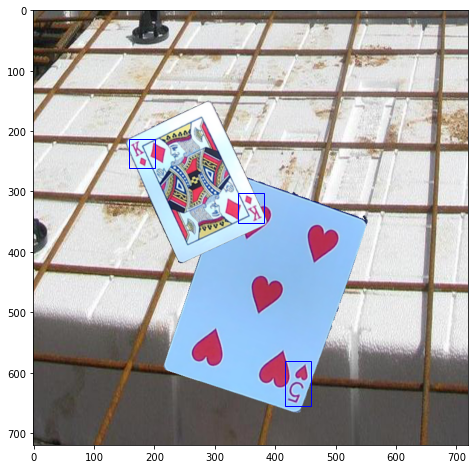

In [22]:
# Test generation of a scene with 2 cards
bg=backgrounds.get_random()
img1,card_val1,hulla1,hullb1=cards.get_random()
img2,card_val2,hulla2,hullb2=cards.get_random()

newimg=Scene(bg,img1,card_val1,hulla1,hullb1,img2,card_val2,hulla2,hullb2)
newimg.display()

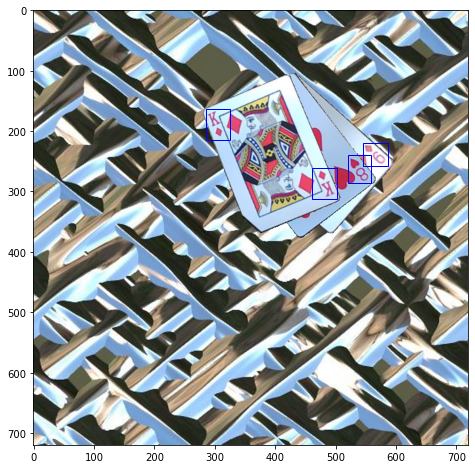

In [23]:
# Test generation of a scene with 3 cards
bg=backgrounds.get_random()
img1,card_val1,hulla1,hullb1=cards.get_random()
img2,card_val2,hulla2,hullb2=cards.get_random()
img3,card_val3,hulla3,hullb3=cards.get_random()

newimg=Scene(bg,img1,card_val1,hulla1,hullb1,img2,card_val2,hulla2,hullb2,img3,card_val3,hulla3,hullb3)
newimg.display()

# Generate the dataset with 2 in the scene


In [ ]:
nb_cards_to_generate=100
save_dir=data_dir /"scenes" / "val"

save_dir.mkdir(parents=True, exist_ok=True)

for i in tqdm(range(nb_cards_to_generate)):
    bg=backgrounds.get_random()
    img1,card_val1,hulla1,hullb1=cards.get_random()
    img2,card_val2,hulla2,hullb2=cards.get_random()
    
    newimg=Scene(bg,img1,card_val1,hulla1,hullb1,img2,card_val2,hulla2,hullb2)
    newimg.write_files(save_dir)

In [ ]:
nb_cards_to_generate=100
save_dir=data_dir /"scenes" / "val"

save_dir.mkdir(parents=True, exist_ok=True)

for i in tqdm(range(nb_cards_to_generate)):
    bg=backgrounds.get_random()
    img1,card_val1,hulla1,hullb1=cards.get_random()
    img2,card_val2,hulla2,hullb2=cards.get_random()
    img3,card_val3,hulla3,hullb3=cards.get_random()
    
    newimg=Scene(bg,img1,card_val1,hulla1,hullb1,img2,card_val2,hulla2,hullb2,img3,card_val3,hulla3,hullb3)
    newimg.write_files(save_dir)

# Generate training dataset

Randomy generate 2 or 3 card scenes

In [ ]:
nb_cards_to_generate=60000
save_dir= data_dir /"scenes" / "train"

save_dir.mkdir(parents=True, exist_ok=True)
for i in tqdm(range(nb_cards_to_generate)):
    bg=backgrounds.get_random()
    img1,card_val1,hulla1,hullb1=cards.get_random()
    img2,card_val2,hulla2,hullb2=cards.get_random()
    
#     Randomly generate 2 or 3 cards in scene
    if random.choice([2, 3]) == 2: 
        newimg=Scene(bg,img1,card_val1,hulla1,hullb1,img2,card_val2,hulla2,hullb2)
        newimg.write_files(save_dir)
    else:
        img3,card_val3,hulla3,hullb3=cards.get_random()
        newimg=Scene(bg,img1,card_val1,hulla1,hullb1,img2,card_val2,hulla2,hullb2,img3,card_val3,hulla3,hullb3)
        newimg.write_files(save_dir)
        

In [ ]:
#!python convert_voc_yolo.py data/scenes/val data/cards.names data/val.txt
!python convert_voc_yolo.py data/scenes/train data/cards.names data/train.txt